# Problem Set 1 - Neural network implementation

Team number: PS 1 B

Team members:
- Giorgio Coppola (224545)
- Minho Kang (239742)
- Sofiya Berdiyeva (246934)

As described in section "2 Neural network implementation" of assignment 1, the goal is to build a shallow neural network from scratch using different approaches. To validate that your code is working and that the network is actually learning something, please use the following MNIST classification task. Finally, please submit proof of the learning progress as described in the assignment.

## Imports

In [32]:
import random
import pandas as pd
import numpy as np
from sklearn import model_selection
import sklearn.datasets as sk_datasets
import torchvision.datasets as torch_datasets
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

from scratch.network import Network
from scratch.res_network import ResNetwork
from pytorch.network import TorchNetwork
from scratch.utils import *

import optuna
from sklearn.metrics import accuracy_score


In [33]:
# Automatically load changes in imported modules
%load_ext autoreload
%autoreload 2

# Explicitly set seed for reproducibility
GLOBAL_RANDOM_STATE = 42

random.seed(GLOBAL_RANDOM_STATE)
np.random.seed(GLOBAL_RANDOM_STATE)

## A) Neural Network Classifier from Scratch

### Data

In [34]:
# Download MNIST dataset
x, y_cat = sk_datasets.fetch_openml('mnist_784', version=1, return_X_y=True, cache=True, as_frame=False)

# Preprocess dataset
x = (x / 255).astype('float32')
y_cat = y_cat.astype(int)
# One-hot encode y
y = np.zeros((len(y_cat), 10))
for i, val in enumerate(y_cat):
    y[i, val] = 1

# Use only small subset of data for faster training
x = x[:1000]
y = y[:1000]

# Split data into train and validation set
x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size=0.2, random_state=GLOBAL_RANDOM_STATE)


### ML Model & Training

In [35]:
fnn = Network(sizes=[784, 128, 64, 10], learning_rate=0.1, epochs=50)
fnn.fit(x_train, y_train, x_val, y_val, cosine_annealing_lr=False)

Epoch: 1, Training Time: 0.56s, Training Accuracy: 44.38%, Validation Accuracy: 41.00%
Epoch: 2, Training Time: 1.21s, Training Accuracy: 74.00%, Validation Accuracy: 70.00%
Epoch: 3, Training Time: 1.84s, Training Accuracy: 82.50%, Validation Accuracy: 80.00%
Epoch: 4, Training Time: 2.50s, Training Accuracy: 88.62%, Validation Accuracy: 82.00%
Epoch: 5, Training Time: 3.14s, Training Accuracy: 92.00%, Validation Accuracy: 83.50%
Epoch: 6, Training Time: 3.78s, Training Accuracy: 93.88%, Validation Accuracy: 84.50%
Epoch: 7, Training Time: 4.67s, Training Accuracy: 95.12%, Validation Accuracy: 83.00%
Epoch: 8, Training Time: 5.45s, Training Accuracy: 95.62%, Validation Accuracy: 83.00%
Epoch: 9, Training Time: 6.21s, Training Accuracy: 96.75%, Validation Accuracy: 84.50%
Epoch: 10, Training Time: 7.35s, Training Accuracy: 97.25%, Validation Accuracy: 85.00%
Epoch: 11, Training Time: 9.42s, Training Accuracy: 97.88%, Validation Accuracy: 84.50%
Epoch: 12, Training Time: 11.01s, Trainin

### Test cosine annealing scheduler

In [36]:
fnn.fit(x_train, y_train, x_val, y_val, cosine_annealing_lr=True)

Epoch: 1, Training Time: 0.87s, Training Accuracy: 99.50%, Validation Accuracy: 90.00%
Epoch: 2, Training Time: 2.06s, Training Accuracy: 99.50%, Validation Accuracy: 89.50%
Epoch: 3, Training Time: 3.38s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 4, Training Time: 4.65s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 5, Training Time: 5.82s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 6, Training Time: 7.13s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 7, Training Time: 9.48s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 8, Training Time: 11.92s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 9, Training Time: 13.26s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 10, Training Time: 14.40s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 11, Training Time: 15.57s, Training Accuracy: 99.62%, Validation Accuracy: 89.50%
Epoch: 12, Training Time: 16.41s, Tra

### Test residual neural network

In [37]:
res_nn = ResNetwork(sizes=[784, 128, 64, 10], learning_rate=0.0005, epochs=100)
res_nn.fit(x_train, y_train, x_val, y_val)

Epoch: 1, Training Time: 0.72s, Training Accuracy: 12.50%, Validation Accuracy: 20.50%
Epoch: 2, Training Time: 1.59s, Training Accuracy: 14.50%, Validation Accuracy: 18.50%
Epoch: 3, Training Time: 2.45s, Training Accuracy: 15.38%, Validation Accuracy: 19.00%
Epoch: 4, Training Time: 3.27s, Training Accuracy: 16.88%, Validation Accuracy: 22.00%
Epoch: 5, Training Time: 4.12s, Training Accuracy: 17.25%, Validation Accuracy: 23.00%
Epoch: 6, Training Time: 4.99s, Training Accuracy: 17.75%, Validation Accuracy: 21.50%
Epoch: 7, Training Time: 5.87s, Training Accuracy: 18.00%, Validation Accuracy: 21.00%
Epoch: 8, Training Time: 6.78s, Training Accuracy: 17.50%, Validation Accuracy: 22.00%
Epoch: 9, Training Time: 8.02s, Training Accuracy: 17.12%, Validation Accuracy: 21.50%
Epoch: 10, Training Time: 9.31s, Training Accuracy: 19.88%, Validation Accuracy: 23.50%
Epoch: 11, Training Time: 10.55s, Training Accuracy: 21.12%, Validation Accuracy: 25.50%
Epoch: 12, Training Time: 11.61s, Traini

## B) Neural Network Classifier using Torch

### Data

In [38]:
# Define data preprocessing steps
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])

# Download MNIST dataset
train_set = torch_datasets.MNIST('data', train=True, download=True, transform=transform)
val_set = torch_datasets.MNIST('data', train=False, download=True, transform=transform)

# Use only small subset of data for faster training
train_set = torch.utils.data.Subset(train_set, range(1000))
val_set = torch.utils.data.Subset(val_set, range(1000))

# Utilize PyTorch DataLoader from simplified & harmonized loading of data
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1)


### ML Model & Training

In [39]:
torch_nn = TorchNetwork(sizes=[784, 128, 64, 10], learning_rate=0.2, epochs=50, random_state=GLOBAL_RANDOM_STATE)
torch_nn.fit(train_loader, val_loader)

Epoch: 1, Training Time: 2.61s, Learning Rate: 0.2, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 2, Training Time: 6.45s, Learning Rate: 0.2, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 3, Training Time: 10.71s, Learning Rate: 0.2, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 4, Training Time: 14.81s, Learning Rate: 0.2, Training Accuracy: 11.70%, Validation Accuracy: 9.90%
Epoch: 5, Training Time: 18.69s, Learning Rate: 0.2, Training Accuracy: 30.70%, Validation Accuracy: 26.80%
Epoch: 6, Training Time: 22.63s, Learning Rate: 0.2, Training Accuracy: 29.00%, Validation Accuracy: 26.80%
Epoch: 7, Training Time: 27.03s, Learning Rate: 0.2, Training Accuracy: 30.10%, Validation Accuracy: 28.10%
Epoch: 8, Training Time: 30.77s, Learning Rate: 0.2, Training Accuracy: 35.80%, Validation Accuracy: 31.30%
Epoch: 9, Training Time: 34.59s, Learning Rate: 0.2, Training Accuracy: 46.20%, Validation Accuracy: 42.60%
Epoch: 10, Training Time: 38.95s, 

## C) Visualize accuracy & hyperparameter tuning

Here, you should compare the accuracy of all trained models. Optionally, you can also show the results of hyperparameter tuning and comment which hyperparameters work best for this task.

In [40]:
def accuracy_plot(model, model_name):
    plt.plot(model.train_accuracies, label='Training Accuracy') #Need to implement in each model
    plt.plot(model.val_accuracies, label='Validation Accuracy') #Need to implement in each model
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy over Epochs - {model_name}')
    plt.legend()
    plt.show()

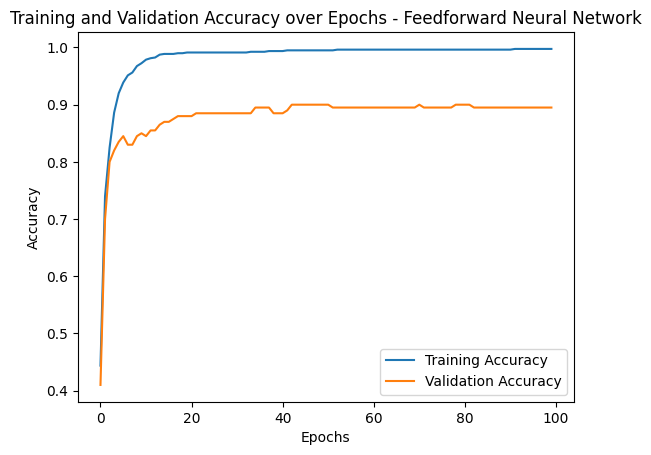

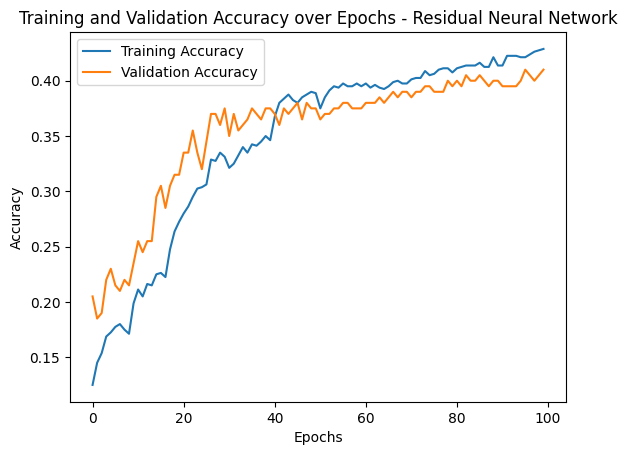

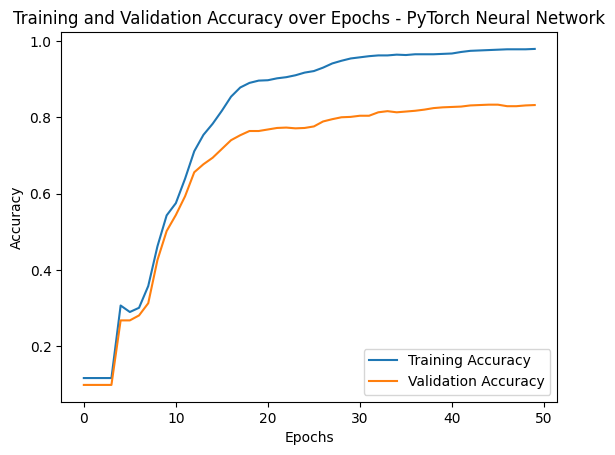

In [41]:
accuracy_plot(fnn, "Feedforward Neural Network")
accuracy_plot(res_nn, "Residual Neural Network")
accuracy_plot(torch_nn, "PyTorch Neural Network")


Feedforworward neural network showed the best results, having relatively smooth trend through epochs for the training accuracy.
Pytorch-based architecture had a 'difficult' start  until the 9th epoch, but managed to overcome it, reaching results somewhat worse than the model written from scratch.
And the residual neeural net implementation performed too poorly and unstable, which motivated us to use optuna for the hyperparameter tuning purposes.

## Hyperparameter tuning with optuna

In [42]:
# Optimization function for Optuna
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_uniform('learning_rate', 1e-5, 1e-2)  # Uniform distribution for learning rate
    epochs = trial.suggest_int('epochs', 50, 150)  # Integer uniform distribution for epochs
    hidden_layer_1 = trial.suggest_int('hidden_layer_1', 64, 256)  # Hidden layer 1 size
    hidden_layer_2 = trial.suggest_int('hidden_layer_2', 32, 128)  # Hidden layer 2 size

    # Define the network with these hyperparameters
    res_nn = ResNetwork(
        sizes=[784, hidden_layer_1, hidden_layer_2, 10],
        learning_rate=learning_rate,
        epochs=epochs
    )

    # Train the network using the training data and validation data
    res_nn.fit(x_train, y_train, x_val, y_val, verbose=False)

    # Evaluate the model on the validation set
    val_accuracy = res_nn.compute_accuracy(x_val, y_val)

    return val_accuracy  # Return the validation accuracy to optimize

# Create an Optuna study to maximize the validation accuracy
study = optuna.create_study(direction='maximize')  # Direction can be 'maximize' for accuracy or 'minimize' for loss

# Optimize the objective function
optuna.logging.set_verbosity(optuna.logging.ERROR)
study.optimize(objective, n_trials=100)  # Perform 100 trials

# Output the best hyperparameters found by Optuna
print('Best trial:', study.best_trial.params)


/tmp/ipython-input-600006187.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 1e-5, 1e-2)  # Uniform distribution for learning rate


Best trial: {'learning_rate': 0.0017077611187331968, 'epochs': 147, 'hidden_layer_1': 122, 'hidden_layer_2': 94}


In [43]:
best_params = study.best_trial.params
best_learning_rate = best_params['learning_rate']
best_epochs = best_params['epochs']
best_hidden_layer_1 = best_params['hidden_layer_1']
best_hidden_layer_2 = best_params['hidden_layer_2']
res_nn_best = ResNetwork(
        sizes=[784, best_hidden_layer_1, best_hidden_layer_2, 10],
        learning_rate=best_learning_rate,
        epochs=best_epochs
    )
res_nn_best.fit(x_train, y_train, x_val, y_val)

Epoch: 1, Training Time: 0.71s, Training Accuracy: 12.25%, Validation Accuracy: 15.50%
Epoch: 2, Training Time: 1.57s, Training Accuracy: 15.00%, Validation Accuracy: 17.50%
Epoch: 3, Training Time: 2.40s, Training Accuracy: 16.25%, Validation Accuracy: 21.00%
Epoch: 4, Training Time: 3.26s, Training Accuracy: 18.00%, Validation Accuracy: 21.50%
Epoch: 5, Training Time: 4.33s, Training Accuracy: 18.88%, Validation Accuracy: 20.00%
Epoch: 6, Training Time: 5.67s, Training Accuracy: 20.88%, Validation Accuracy: 25.00%
Epoch: 7, Training Time: 6.99s, Training Accuracy: 19.88%, Validation Accuracy: 24.00%
Epoch: 8, Training Time: 8.25s, Training Accuracy: 22.25%, Validation Accuracy: 26.00%
Epoch: 9, Training Time: 9.11s, Training Accuracy: 30.12%, Validation Accuracy: 33.50%
Epoch: 10, Training Time: 9.97s, Training Accuracy: 30.38%, Validation Accuracy: 34.50%
Epoch: 11, Training Time: 10.84s, Training Accuracy: 29.50%, Validation Accuracy: 35.00%
Epoch: 12, Training Time: 11.69s, Traini

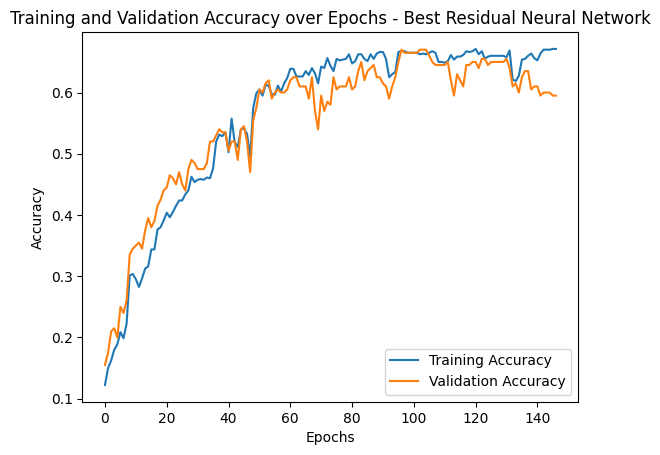

In [44]:
accuracy_plot(res_nn_best, "Best Residual Neural Network")

The performance of RNN significantly improved with the optimized hyperparameters, but remained poor in comparison with the other models.